# *** Compare SFR stages Vs RIV stages ***

- This check is for NBr43, but it can be later modified to compare different MdlNs.
- SFR stage was computed based on the shapefile that was given to us by Brabantse Delta.
- RIV stage comes from the RIV IDF files that were given to us by Deltares.
- There are 5 RIV systems, which makes things a bit complicated. There are 4 parameters per system. One of them is density, which is set to 1 always. Here is a more detailed explanation:
    - Sys 1: DETAILWATERGANGEN. Contains the detailed network. This is the only system that really matters in our region of interest.:
        - **Conductance**: ranges from 5-90 m2/d, with a mean value of 21.39 m2/d.
        - **Stage**: ranges from 0.94-24.43 m NAP, with a mean value of 10.82 m NAP.
        - **Bottom**: is the same as stage, so this system can only drain water away, not add water to the aquifer.
        Those parameters don't change year round
    - Sys 2: RIV.  :
        - **Conductance**: 0 everywhere in our model. So this system does not play a role. 
    - Sys 3: DRN. :
        - **Conductance**: ranges from 0 to 96.9 m2/d, with a mean value of 16.3 m2/d.
        - **Stage**: 
            - **winter**: 9 m NAP everywhere (in our model region). There is only 1 raster cell with a value, so I wonder if those even get to MF.
            - **summer**: 9 m NAP everywhere (in our model region). " " "
        - **Bottom**:
            - **winter**: 

# 0. Initial

## 0.0. Imports

In [36]:
import imod

In [1]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G

In [2]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(G)

<module 'WS_Mdl.geo' from 'G:\\code\\WS_Mdl\\geo.py'>

In [67]:
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import pandas as pd
from datetime import datetime as DT
import matplotlib.pyplot as plt
from pathlib import Path
import re
import xarray as xr

In [4]:
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
# import contextlib

## 0.1. Options

In [5]:
U.set_verbose(False)

In [6]:
MdlN = 'NBr40'

# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

In [7]:
MdlN_RIV = 'NBr43'

# Load paths and variables from PRJ & INI
d_Pa_RIV = U.get_MdlN_Pa(MdlN_RIV)
Pa_PRJ_RIV = d_Pa_RIV['PRJ']
Dir_PRJ_RIV = PDN(Pa_PRJ_RIV)

# 1. Load Stuff

## 1.0. Load PRJ

In [8]:
PRJ, PRJ_OBS = UIM.r_PRJ_with_OBS(Pa_PRJ)

## 1.1. Load SFR

In [9]:
d_Pa.keys()

dict_keys(['imod_V', 'Mdl', 'MdlN', 'Pa_Mdl', 'Smk_temp', 'In', 'PoP', 'code', 'pixi', 'coupler_Exe', 'MF6_DLL', 'MSW_DLL', 'INI', 'BAT', 'PRJ', 'Smk', 'Sim', 'Pa_MdlN', 'MF6', 'MSW', 'TOML', 'TOML_iMOD5', 'LST_Sim', 'LST_Mdl', 'NAM_Sim', 'NAM_Mdl', 'Sim_In', 'Sim_Out', 'SFR', 'Out_HD', 'Out_HD_Bin', 'DIS_GRB', 'PoP_Out_MdlN', 'MM'])

In [10]:
U.set_verbose(False)
GDF_SFR = U.SFR_PkgD_to_DF(MdlN)
GDF_SFR

,rno,k,i,j,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,line_id,X,Y
0,1,5,291,366,32.71004,1.0,0.0001,18.899851,0.1,0.076429,0.037,1,1,0,7711,122237.5,388937.5
1,2,5,290,365,33.563854,1.0,0.0001,18.899851,0.1,0.074485,0.037,2,1,0,7711,122212.5,388962.5
2,3,5,290,364,3.111411,1.0,0.0001,18.899851,0.1,0.160699,0.037,2,1,0,7711,122187.5,388962.5
3,4,5,289,364,30.346876,1.0,0.0001,18.899851,0.1,0.065905,0.037,2,1,0,7711,122187.5,388987.5
4,5,5,289,363,7.194803,1.0,0.0001,18.899851,0.1,0.138989,0.037,2,1,0,7711,122162.5,388987.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23888,23889,3,19,72,25.761385,1.0,0.0001,4.785,0.1,0.097044,0.037,2,1,0,1575,114887.5,395737.5
23889,23890,3,19,71,20.574833,1.0,0.0001,4.785,0.1,0.072905,0.037,2,1,0,1575,114862.5,395737.5
23890,23891,3,20,71,5.187648,1.0,0.0001,4.785,0.1,0.67468,0.037,2,1,0,1575,114862.5,395712.5
23891,23892,3,20,70,25.803545,1.0,0.0001,4.785,0.1,0.116263,0.037,2,1,0,1575,114837.5,395712.5


## 1.2. Load RIV

In [11]:
PRJ.keys()

dict_keys(['(cap)', 'extra', '(bnd)', '(top)', '(bot)', '(khv)', '(kva)', '(shd)', '(sto)', '(spy)', '(hfb)', '(drn)', '(wel)', '(pcg)', '(chd)', 'periods', 'species'])

In [12]:
PRJ['periods']

{'1990-04-01': '01-04-1990 00:00:00', '1990-10-01': '01-10-1990 00:00:00'}

In [13]:
PRJ_RIV, PRJ_OBS_RIV = UIM.r_PRJ_with_OBS(Pa_PRJ_RIV)

In [15]:
PRJ_RIV

{'(cap)': {'boundary': [{'active': True,
    'is_constant': 2,
    'layer': 1,
    'factor': 1.0,
    'addition': 0.0,
    'constant': -9999.0,
    'path': WindowsPath('C:/Users/Karam014/AppData/In/BND/BND_L1_NBr1.IDF')}],
  'landuse': [{'active': True,
    'is_constant': 2,
    'layer': 1,
    'factor': 1.0,
    'addition': 0.0,
    'constant': 1e+20,
    'path': WindowsPath('C:/Users/Karam014/AppData/In/CAP/LGN/LGN_NBr1.idf')}],
  'rootzone_thickness': [{'active': True,
    'is_constant': 2,
    'layer': 1,
    'factor': 1.0,
    'addition': 0.0,
    'constant': 1e+20,
    'path': WindowsPath('C:/Users/Karam014/AppData/In/CAP/RZN/RZN_NBr1.idf')}],
  'soil_physical_unit': [{'active': True,
    'is_constant': 2,
    'layer': 1,
    'factor': 1.0,
    'addition': 0.0,
    'constant': 1e+20,
    'path': WindowsPath('C:/Users/Karam014/AppData/In/CAP/SFU/SFU_NBr1.idf')}],
  'meteo_station_number': [{'active': True,
    'is_constant': 2,
    'layer': 1,
    'factor': 1.0,
    'addition': 0.

In [17]:
PRJ_RIV.keys()

dict_keys(['(cap)', 'extra', '(bnd)', '(top)', '(bot)', '(khv)', '(kva)', '(shd)', '(sto)', '(spy)', '(hfb)', '(drn)', '(riv)', '(wel)', '(pcg)', '(chd)', 'periods', 'species'])

In [29]:
PRJ_RIV['(riv)'].keys()

dict_keys(['time', 'conductance', 'stage', 'bottom_elevation', 'infiltration_factor', 'n_system', 'active'])

In [33]:
for i in PRJ_RIV['(riv)']['conductance']:
    print(i['path'])

C:\Users\Karam014\AppData\In\RIV\RIV_Cond_DETAILWATERGANGEN_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_RIV_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_DRN_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_Maas_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_Polderpeil_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_DETAILWATERGANGEN_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_RIV_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_DRN_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_Maas_NBr1.IDF
C:\Users\Karam014\AppData\In\RIV\RIV_Cond_Polderpeil_NBr1.IDF


# -1 Proof that RIV Cond has more cells with values than RIV Stage

In [ ]:
# A = UIM.xr_clip_Mdl_Aa(imod.idf.open("G:/models/NBr/In/RIV/RIV_Cond_DETAILWATERGANGEN_NBr1.IDF"), MdlN)

In [ ]:
# B = UIM.xr_clip_Mdl_Aa(imod.idf.open("G:/models/NBr/In/RIV/RIV_Stg_DETAILWATERGANGEN_NBr1.IDF"), MdlN)

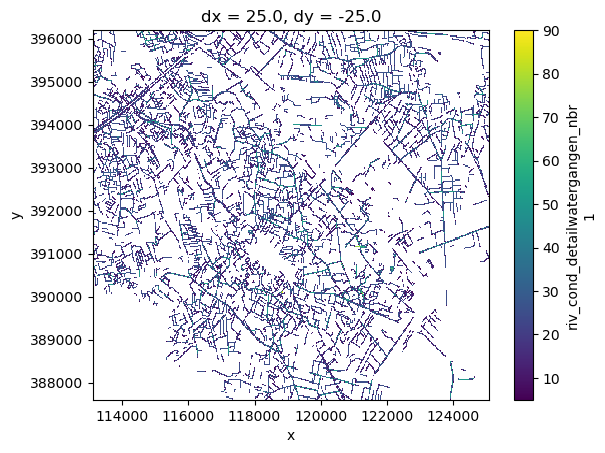

In [ ]:
# A.plot()

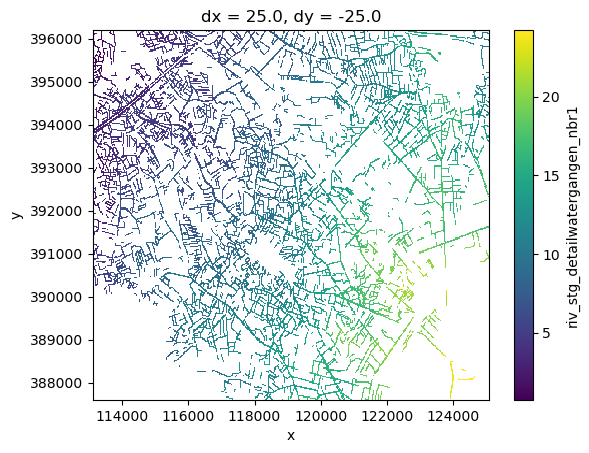

In [ ]:
# B.plot()

In [ ]:
# B.where(A.isnull()).sum().values

array(0., dtype=float32)

In [ ]:
# A.where(B.isnull()).sum().values

array(2215., dtype=float32)